#  Cells Colonies Detection

## Contents

- [EDA](#EDA)
- [Prepare Dataset for Training using YOLOv8](#prepare-dataset)
- [Train YOLO](#train-yolo)
- [TEST Dataset Validation](#test-dataset)
- [Inference](#Inference)

In [2]:
%load_ext autoreload
%autoreload 2

import json
import os
from pathlib import Path

from typing import List, Tuple, Union
import shutil

import random
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
from skmultilearn.model_selection import IterativeStratification

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cv2
from PIL import Image

import torch

import ultralytics
from ultralytics import YOLO
ultralytics.checks()

import warnings
warnings.filterwarnings('ignore')

Ultralytics YOLOv8.1.14 🚀 Python-3.9.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
Setup complete ✅ (16 CPUs, 15.7 GB RAM, 362.9/618.9 GB disk)


In [57]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(100)

In [58]:
DATA_PATH = "./data"
DATASET_PATH = "./datasets"

## EDA <a class="anchor" id="eda"></a>

In [59]:
# parse annotation data
parsed_data = []
for dirpath, _, file_names in os.walk(DATA_PATH):
    for file_name in file_names:
        if file_name[-4:]=='json':
            file_path = os.path.join(dirpath, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)
            for file, filedata in data.items():
                filename = filedata['filename']
                for region in filedata['regions']:
                    shape_attr = region['shape_attributes']
                    region_attr = region['region_attributes']
                    parsed_data.append({
                        'filename': filename,
                        'shape_name': shape_attr.get('name'),
                        'x': shape_attr.get('x'),
                        'y': shape_attr.get('y'),
                        'width': shape_attr.get('width'),
                        'height': shape_attr.get('height'),
                        'class_name': region_attr.get('Type')
                    })

# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data)
df.sample(5)

filename shape_name     x     y  width  height class_name
1701  чашка 8.2.jpg       rect  3302  5056    126     150      Mixed
1283    чашка 7.jpg       rect  3202  3593    145     152      Mixed
1403    чашка 7.jpg       rect  3147  7299    242     219      Mixed
31     чашка 10.jpg       rect  3292  1382    150     150      Mixed
625    чашка 13.jpg       rect  3668  5991    226     257      Mixed

In [60]:
#Delete Dublicates
df = df.drop_duplicates()

In [61]:
#Create class dictionary for labels 
class_dict = {'Mixed': 0, 'Diffuse': 1, 'Dense': 2}
df['class_num']= df['class_name']
df['class_num'].replace(class_dict, inplace=True)
df['class_num'].fillna(-1, inplace=True)
df['class_num']=df['class_num'].astype('int8')

In [62]:
#Explore bboxes with None class
df[df['class_num']== -1]

filename shape_name     x     y  width  height class_name  class_num
111   чашка 10.jpg       rect  1587  6687    237     213       None         -1
411   чашка 12.jpg       rect  4007  2433    167     185       None         -1
477   чашка 12.jpg       rect  1684  4736    186     143       None         -1
871    чашка 4.jpg       rect  3713  6017    201     136       None         -1
1099   чашка 6.jpg       rect  3547  1249    211     124       None         -1

In [73]:
# Replace undefined 'class_num' with the mode of 'class_num'
mode_class_num = df['class_num'].mode()[0]
df.loc[df['class_num'] == -1, 'class_num'] = mode_class_num

# Replace undefined 'class_name' with 'Mixed'
df.loc[pd.isna(df['class_name']), 'class_name'] = 'Mixed'

# Print unique class numbers
unique_class_nums = df['class_num'].unique()
print(unique_class_nums)

[2 0 1]


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, 0 to 1810
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    1682 non-null   object
 1   shape_name  1682 non-null   object
 2   x           1682 non-null   int64 
 3   y           1682 non-null   int64 
 4   width       1682 non-null   int64 
 5   height      1682 non-null   int64 
 6   class_name  1682 non-null   object
 7   class_num   1682 non-null   int8  
dtypes: int64(4), int8(1), object(3)
memory usage: 106.8+ KB


In [75]:
#Function to visualize images with bboxes
def draw_bboxes(images: List[str], datapath: str, df: pd.DataFrame, figsize: Tuple[int, int] = (15, 5), plot_row: int = 2, plot_col: int = 2):
    plt.figure(figsize=figsize)
    for i, image_file in enumerate(images):
        img_path = os.path.join(datapath, image_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        image_data = df[df['filename'] == image_file]
        for _, row in image_data.iterrows():
            if row['class_num'] == 0:
                color = (255, 165, 0) # orange for 'Mixed'
            elif row['class_num'] == 1:
                color = (0, 255, 0)  # Green for 'Diffuse'
            elif row['class_num'] == 2:
                color = (0, 0, 255)  # Blue for 'Dense'
            else:
                color = (255, 0, 0)   # red for undefined classes
            cv2.rectangle(image, (row.x, row.y), (row.x + row.width, row.y + row.height), color, 10)
        ax = plt.subplot(plot_row, plot_col, i + 1)
        ax.set_title(image_file, fontsize = 7)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

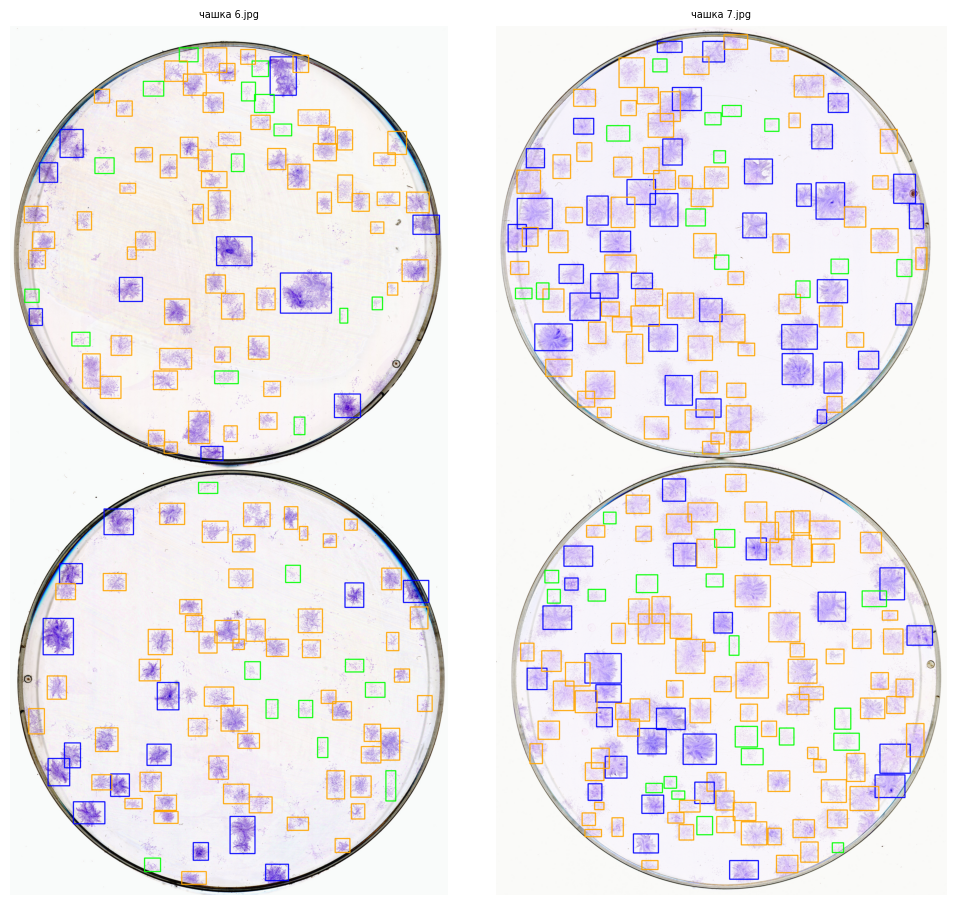

In [77]:
#Visualize random images with bboxes
NUM_IMAGES = 2
unique_images = np.random.choice(df['filename'].unique(), NUM_IMAGES, replace=False)
draw_bboxes(unique_images, datapath=DATA_PATH, df=df, figsize=(10, 18), plot_row=2, plot_col=2)

In [78]:
#Add column with image size
df['im_size'] = None
for i, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, row['filename'])
    image = Image.open(img_path)
    im_size = image.size
    df.at[i, 'im_size'] = im_size
df.sample(3)

filename shape_name     x     y  width  height class_name  \
600    чашка 13.jpg       rect  2170  7006    232     287      Dense   
1462  чашка 8.1.jpg       rect   878  1360    340     237      Dense   
1127    чашка 6.jpg       rect  1460  4671    243     207      Mixed   

      class_num       im_size  
600           2  (4267, 8520)  
1462          2  (4352, 8498)  
1127          0  (4272, 8498)

## Check and Clean dataset from incorrect and overlapping bboxes

In [79]:
#Calculate bboxes area
df['bbox_area'] = df['width'] * df['height']
df['bbox_area_rel'] = df.apply(lambda row: row['bbox_area'] / (row['im_size'][0] * row['im_size'][1]), axis=1)
df.sort_values(by='bbox_area', ascending=False).head(3)

filename shape_name     x     y  width  height class_name  \
1081   чашка 6.jpg       rect  2637  2422    498     392      Dense   
357   чашка 11.jpg       rect  1269  5111    435     346      Mixed   
803    чашка 4.jpg       rect   389  1623    370     389      Dense   

      class_num       im_size  bbox_area  bbox_area_rel  
1081          2  (4272, 8498)     195216       0.005377  
357           0  (4432, 8498)     150510       0.003996  
803           2  (4245, 8498)     143930       0.003990

<Axes: >

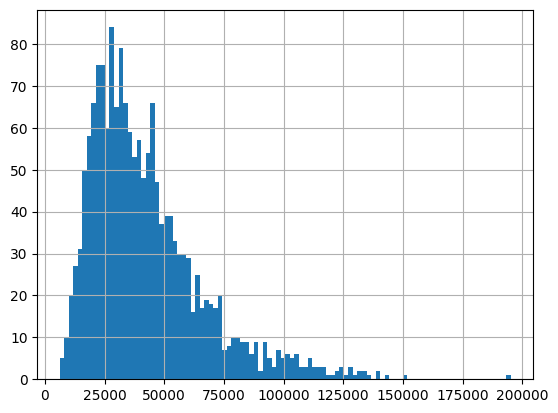

In [80]:
df['bbox_area'].hist(bins=100)

In [81]:
#Check for pairs of bounding boxes with IoU > threshold (not accurate annotation)
def calculate_bbox(row):
    x_min = row['x']
    y_min = row['y']
    x_max = row['x'] + row['width']
    y_max = row['y'] + row['height']
    return x_min, y_min, x_max, y_max


def calculate_iou(box1, box2):
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou

THRESHOLD = 0.3

# Add bbox coordinates to the DataFrame
df_iou = df.copy()
df_iou['bbox_coords'] = df_iou.apply(calculate_bbox, axis=1)

# Find pairs of bounding boxes with IoU > Threshold
overlapping_bboxes = []

for i, row1 in df_iou.iterrows():
    for j, row2 in df_iou.iterrows():
        if i < j and row1['filename'] == row2['filename']:
            iou = calculate_iou(row1['bbox_coords'], row2['bbox_coords'])
            if iou > THRESHOLD:
                overlapping_bboxes.append((row1['filename'], i, row1['class_name'], j, row2['class_name'], iou))

# Convert the list of overlapping bboxes to a DataFrame
overlapping_df = pd.DataFrame(overlapping_bboxes, columns=['filename', 'bbox1_index', 'bbox1_class', 'bbox2_index', 'bbox2_class', 'iou'])

print(overlapping_df)

Empty DataFrame
Columns: [filename, bbox1_index, bbox1_class, bbox2_index, bbox2_class, iou]
Index: []


In [82]:
#Export filtered dataframe
df.to_csv(os.path.join(DATA_PATH, 'dataset.csv'), index=False)

#### Ввиду того что датаcет очень ограниченный а также изображения содержат 2 идентичные чаши было приято решение разделить каждое изображение на 2 части, что позволило увеличить количество данных, уменьшить разрешение изображений и сделать их субквадратным, что позвит избежать скажений при ресайзе

## Разделение изображений на 2 части 

In [83]:
NEW_PATH = './data_aug'

In [20]:
os.makedirs(NEW_PATH, exist_ok=True)

def adjust_bbox(row, height, half):
    x_min, y_min, x_max, y_max = row['x'], row['y'], row['x'] + row['width'], row['y'] + row['height']
    if half == 'upper':
        if y_min < height // 2:
            if y_max >= height // 2:
                return [x_min, y_min, row['width'], ((height // 2) - y_min)]
            return [x_min, y_min, row['width'], row['height']]
        else:
            return None

    elif half == 'lower':
        if y_max > height // 2:
            return [x_min, y_min - height // 2, row['width'], row['height']]
        else:
            return None


new_rows = []

for _, row in df.iterrows():
    image_path = row['filename']
    image = Image.open(os.path.join(DATA_PATH, image_path))
    width, height = image.size

    upper_half = image.crop((0, 0, width, (height // 2)))
    lower_half = image.crop((0, (height // 2), width, height))
    
    # Saving the images (modify the paths as per your requirements)
    upper_path = f'{image_path[:-4]}_1.jpg'
    lower_path = f'{image_path[:-4]}_2.jpg'
    upper_half.save(os.path.join(NEW_PATH, upper_path))
    lower_half.save(os.path.join(NEW_PATH, lower_path))
    
    # Adjust the bounding box for the upper half
    new_bbox_upper = adjust_bbox(row, height, 'upper')
    if new_bbox_upper:
        new_row_upper = row.copy()
        new_row_upper['filename'] = upper_path
        new_row_upper['x'], new_row_upper['y'], new_row_upper['width'], new_row_upper['height'] = new_bbox_upper
        new_rows.append(new_row_upper)

    # Adjust the bounding box for the lower half
    new_bbox_lower = adjust_bbox(row, height, 'lower')
    if new_bbox_lower:
        new_row_lower = row.copy()
        new_row_lower['filename'] = lower_path
        new_row_lower['x'], new_row_lower['y'], new_row_lower['width'], new_row_lower['height'] = new_bbox_lower
        new_rows.append(new_row_lower)

new_df = pd.DataFrame(new_rows)
new_df=new_df.drop(columns=['im_size', 'bbox_area_rel', 'bbox_area'])

# Save the new dataframe
new_df.to_csv(os.path.join(NEW_PATH,'dataset_im_divide.csv'), index=False)

new_df.head(10)

filename shape_name     x     y  width  height class_name  class_num
0  чашка 10_1.jpg       rect  1074   695    189     245      Dense          2
1  чашка 10_1.jpg       rect  1634   537    284     150      Dense          2
2  чашка 10_1.jpg       rect  2179   229    268     213      Dense          2
3  чашка 10_1.jpg       rect  2779   308    174     166      Dense          2
4  чашка 10_1.jpg       rect  3513   876    245     332      Dense          2
5  чашка 10_1.jpg       rect  3387   655    253     189      Dense          2
6  чашка 10_1.jpg       rect  4058  1713    166     268      Dense          2
7  чашка 10_1.jpg       rect  3837  2432    261     205      Dense          2
8  чашка 10_1.jpg       rect  3711  2155    332     276      Mixed          0
9  чашка 10_1.jpg       rect  3363  3308    324     339      Dense          2

In [84]:
new_df = pd.read_csv(os.path.join(NEW_PATH,'dataset_im_divide.csv'))
new_df['im_size'] = None  # Initialize the column

for i, row in new_df.iterrows():
    img_path = os.path.join(NEW_PATH, row['filename'])
    image = Image.open(img_path)
    im_size = image.size
    new_df.at[i, 'im_size'] = im_size  # Update the 'im_size' for each row

new_df.sample(3)

filename shape_name     x     y  width  height class_name  \
1080    чашка 7_1.jpg       rect  1009  1994    293     199      Dense   
824     чашка 5_1.jpg       rect  2914  3557    130     156    Diffuse   
1407  чашка 8.1_2.jpg       rect  3842  1554    229     324      Mixed   

      class_num       im_size  
1080          2  (4363, 4207)  
824           1  (4245, 4249)  
1407          0  (4352, 4249)

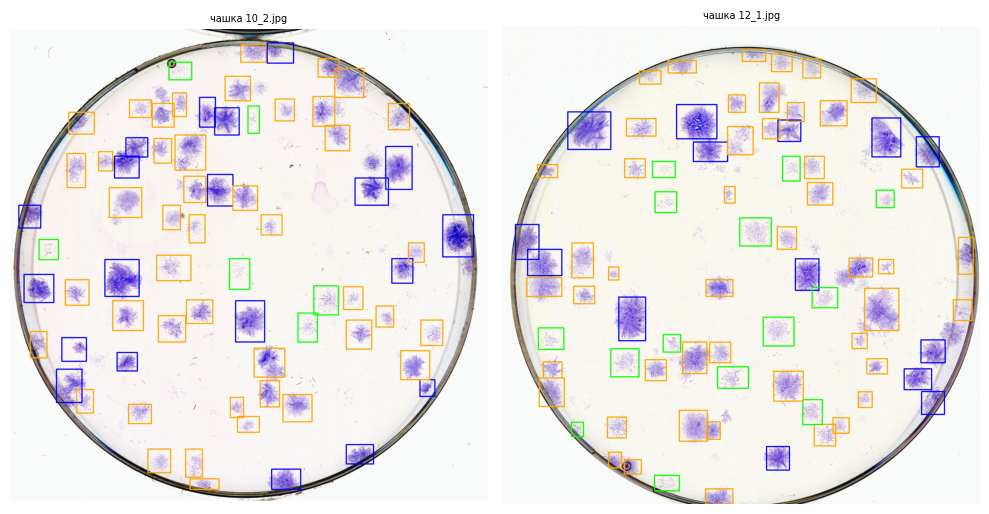

In [85]:
#Visualize random images with bboxes
NUM_IMAGES = 2
unique_images = np.random.choice(new_df['filename'].unique(), NUM_IMAGES, replace=False)
draw_bboxes(unique_images, datapath=NEW_PATH, df=new_df, figsize=(10, 18), plot_row=2, plot_col=2)

## Analysis of classes and bboxes

In [86]:
df_ini = df
df = new_df

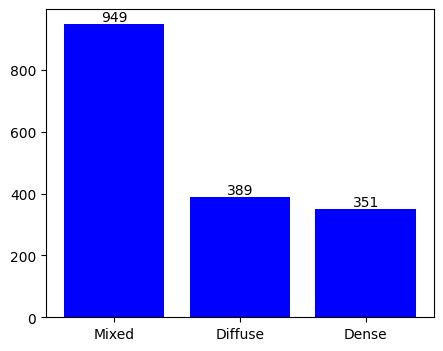

In [87]:
#Class Balance analysis

plt.figure(figsize=(5, 4))

class_count = df['class_name'].value_counts()
bars = plt.bar(class_count.index, class_count.values, color='blue')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')
plt.show()

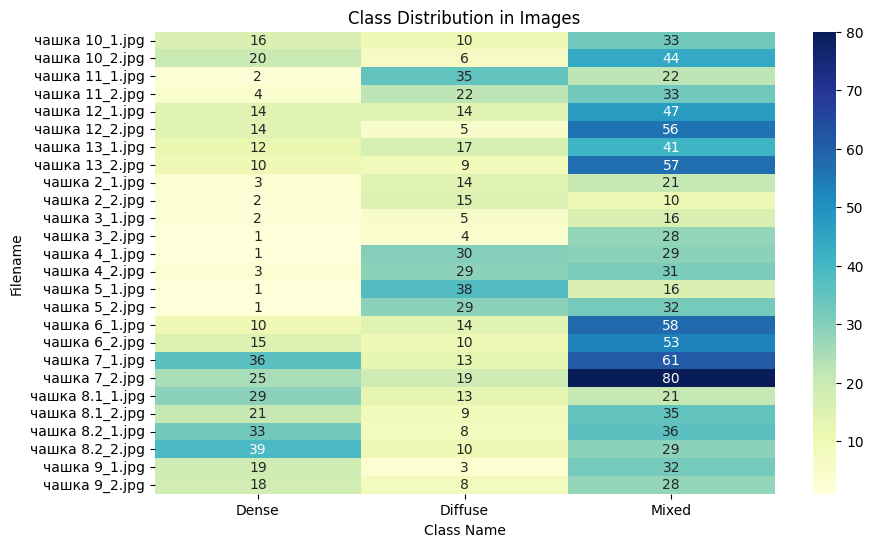

In [88]:
# Counting the number of occurrences of each class in each image
class_distribution = df.groupby('filename')['class_name'].value_counts().unstack(fill_value=0)

# Plotting the distribution using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(class_distribution, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Class Distribution in Images')
plt.xlabel('Class Name')
plt.ylabel('Filename')
plt.show()

## Prepare Dataset for YoloV8 <a class="anchor" id="prepare-dataset"></a>

### Creat txt files with YOLO annotation

In [89]:
def convert_bbox_to_yolo(x, y, width, height, img_width, img_height):
    """
    Convert bounding box format from top-left coordinates to YOLO format.
    """
    x_center = (x + width / 2) / img_width
    y_center = (y + height / 2) / img_height
    width = width / img_width
    height = height / img_height
    return x_center, y_center, width, height

annotations = {}

for index, row in df.iterrows():
    filename = row['filename'].strip()
    class_num = int(row['class_num'])
    x, y, width, height = row['x'], row['y'], row['width'], row['height']
    # Process 'im_size' to extract image width and height
    img_size_str = row['im_size']
    img_width, img_height = int(img_size_str[0]), int(img_size_str[1])
    # Convert to YOLO format
    x_center, y_center, width, height = convert_bbox_to_yolo(x, y, width, height, img_width, img_height)
    # Prepare annotation line
    annotation_line = f"{class_num} {x_center} {y_center} {width} {height}\n"
    # Add annotation line to corresponding file
    if filename not in annotations:
        annotations[filename] = []
    annotations[filename].append(annotation_line)


for filename, lines in annotations.items():
    base_filename = os.path.splitext(filename)[0]
    output_file = os.path.join(NEW_PATH, base_filename + '.txt')
    with open(output_file, 'w') as f:
        f.writelines(lines)

### Creat Train, Valid and Test folders for YOLO training using Stratified Test Split

In [90]:
#function for onehot encoding for classes
def onehot_classes(df_class_list: pd.DataFrame, class_dict: dict) -> pd.DataFrame:
    df_one_hot = pd.DataFrame(np.zeros((len(df_class_list), len(class_dict))), columns=[str(i) for i in range(len(class_dict))])
    df_one_hot.astype('int8')
    df_one_hot.index = df_class_list.index

    for index, row in df_class_list.iterrows():
        for class_label in row['class_num']:
            class_label_str = str(class_label)
            df_one_hot.at[index, class_label_str] += 1
    df_class_list = pd.concat([df_class_list, df_one_hot], axis=1)
    return df_class_list

In [91]:
# Create list of classes for each image
df_class_list = df.groupby('filename')['class_num'].apply(list).reset_index()

# Make one hot encoding for classes for further split
df_class_list = onehot_classes(df_class_list, class_dict)

# df_class_list

In [92]:
def stratify_shuffle_split_subsets(
    annotation: pd.DataFrame,
    train_fraction: float = 0.8,
) -> Tuple[np.ndarray, np.ndarray]:

    x_columns = ['filename']
    y_columns = list(annotation.select_dtypes('float').columns)

    all_x = annotation[x_columns].to_numpy()
    all_y = annotation[y_columns].to_numpy()

    train_indexes, valid_indexes = _split(all_x, all_y, distribution=[1 - train_fraction, train_fraction])
    x_train, x_valid = all_x[train_indexes], all_x[valid_indexes]

    x_train = [i[0] for i in x_train]
    x_valid = [i[0] for i in x_valid]

    return x_train, x_valid


def _split(
    xs: np.array,
    ys: np.array,
    distribution: Union[None, List[float]] = None,
) -> Tuple[np.array, np.array]:
    stratifier = IterativeStratification(n_splits=2, sample_distribution_per_fold=distribution)
    first_indexes, second_indexes = next(stratifier.split(X=xs, y=ys))

    return first_indexes, second_indexes

In [93]:
TRAIN_FRACTION = 0.8
DATASET_MODES = ['train', 'valid']

x_train, x_valid = stratify_shuffle_split_subsets(df_class_list, TRAIN_FRACTION)
subsets = x_train, x_valid
print(len(x_train), len(x_valid))

subsets_dict = {}
for name, subset in zip(DATASET_MODES, subsets):
    subsets_dict[name] = subset

21 5


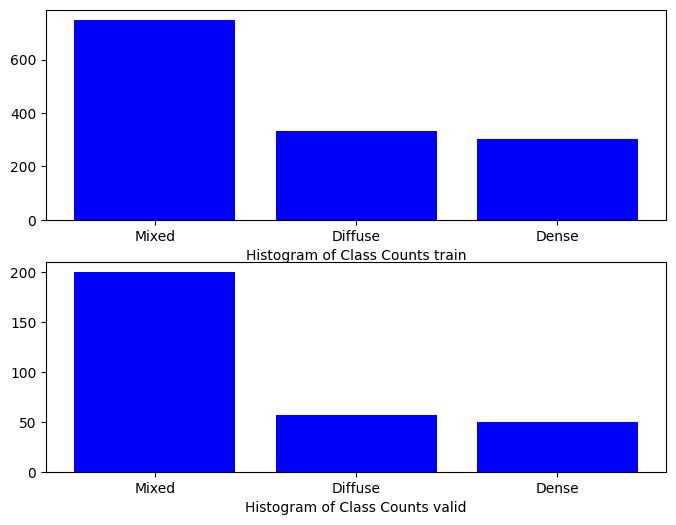

In [94]:
#Class Balance after split
plt.figure(figsize=(8, 6))

for num, subset in enumerate((x_train, x_valid)):
    ax = plt.subplot(2, 1, num + 1)
    class_count = df[df['filename'].isin(subset)]['class_name'].value_counts()
    ax.bar(class_count.index, class_count.values, color='blue')
    ax.set_xlabel('Class ID')
    ax.set_xlabel('Count')
    ax.set_xlabel(f'Histogram of Class Counts {DATASET_MODES[num]}')
plt.show()

In [95]:
#Copy files and annotations accourding to YOLO data structure
def copy_to_folders(
    dest_folder: str,
    source_folder: str,
    dataset_modes: list,
    subsets_dict: dict,
) -> None:
    dest_folder = Path(dest_folder)
    mode_source_folder = Path(source_folder)

    for mode in dataset_modes:
        dest_path_image = dest_folder / 'images' / mode
        dest_path_labels = dest_folder / 'labels' / mode

        dest_path_image.mkdir(parents=True, exist_ok=True)
        dest_path_labels.mkdir(parents=True, exist_ok=True)

        for image in subsets_dict[mode]:
            initial_path_image = mode_source_folder / image
            destination_path_image = dest_path_image / image
            
            
            img = cv2.imread(initial_path_image, 1)
            # # medianBlur
            img = cv2.medianBlur(img, 5)
            # Closing
            # kernel5 = np.ones((3,3),np.uint8)
            # image = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel5)
            
            cv2.imwrite(os.path.join(destination_path_image), img)

            initial_path_labels = mode_source_folder / f"{image[:-3]}txt"
            destination_path_labels = dest_path_labels / f"{image[:-3]}txt"
            shutil.copy(initial_path_labels, destination_path_labels)


copy_to_folders(DATASET_PATH, NEW_PATH, DATASET_MODES, subsets_dict)

In [96]:
#Check number of files copied is correct
for mode in DATASET_MODES:
    mode = str(mode)
    folder_path = Path('./datasets/images') / mode
    file_count = len([file for file in folder_path.iterdir() if file.is_file()])
    print(file_count)

21
5


### Данные были разделены с сохранением распределения по классам обьектов. Легкое размытие изображений помогло повысить качество дальнейшего обучения. Ввиду ограничения данных и упрощения данные были разделены на трейн и валидация (без тестовой выборки)

## Create yaml file

In [97]:
import yaml

# YAML content as specified
yaml_content = {
    'path': DATASET_PATH,
    'train': 'images/train',
    'val': 'images/valid',
    'nc': 3,
    'names': {0: '0', 1: '1', 2: '2'}
}

# Path for the YAML file
yaml_file_path = Path(DATASET_PATH) / 'dataset_cells.yaml'

# Write the YAML file
with open(yaml_file_path, 'w') as file:
    yaml.dump(yaml_content, file)

yaml_file_path  # Return the path of the created YAML file

WindowsPath('datasets/dataset_cells.yaml')

## Train YOLOv8 <a class="anchor" id="train-yolo"></a>

### В качестве архитектуры была выбрана Yolov8 как SOTA в решении задач детекции обьектов. Ввиду ограничения вычислительных ресурсов была использована small версия. В процессе настрйоки модели подбирались гиперпараметры, включая аугментации.

In [ ]:
##train base case with unchanged images (folder 'runs/detect/train_base')
# !yolo task=detect mode=train model=yolov8s.pt data="./datasets/dataset_cells.yaml" epochs=60 imgsz=1280 batch=4 iou=0.6 device=0 lr0=0.005 lrf=0.01 show_labels=False show_conf=False plots=True line_width=3

In [ ]:
# Train the model on divided images (folder 'runs/detect/train_divided')
torch.cuda.empty_cache() 
!yolo task=detect mode=train model=yolov8s.pt data="./datasets/dataset_cells.yaml" epochs=100 imgsz=960 batch=3 iou=0.6 device=0 lr0=0.01 lrf=0.01 flipud=0.5 show_labels=False show_conf=False plots=True line_width=3

In [55]:
# # Train the model on divided images (folder 'runs/detect/train_divided_aug')
# torch.cuda.empty_cache() 
# !yolo task=detect mode=train model=yolov8n.pt data="./datasets/dataset_cells.yaml" verbose=False epochs=600 patience=100 imgsz=960 batch=3 iou=0.6 device=0 lr0=0.01 lrf=0.01 cos_lr=True flipud=0.5 copy_paste=0.2 close_mosaic=0 show_labels=False show_conf=False plots=True line_width=3

New https://pypi.org/project/ultralytics/8.1.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.14 🚀 Python-3.9.10 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 4096MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=./datasets/dataset_cells.yaml, epochs=600, time=None, patience=100, batch=3, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=N


train: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\train.cache... 21 images, 0 backgrounds, 3 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]
train: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\train.cache... 21 images, 0 backgrounds, 3 corrupt: 100%|██████████| 21/21 [00:00<?, ?it/s]

val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\valid.cache... 5 images, 0 backgrounds, 2 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]
val: Scanning C:\Users\julia\CV\RUDCODE_task\datasets\labels\valid.cache... 5 images, 0 backgrounds, 2 corrupt: 100%|██████████| 5/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]
      1/600      1.11G       2.39      3.992       1.36        368        640:   0%|          | 0/6 [00:04<?, ?it/s]
      1/600      1.11G       2.39      3.992       1.36        368        640:  17%|█▋        | 1/6 [00:04<00:22,  4.56s/it]
      1/600      1.11G      2.479       3.94      1.583        148        640:  17%|█▋        | 1/6 [00:04<

## Result of Training

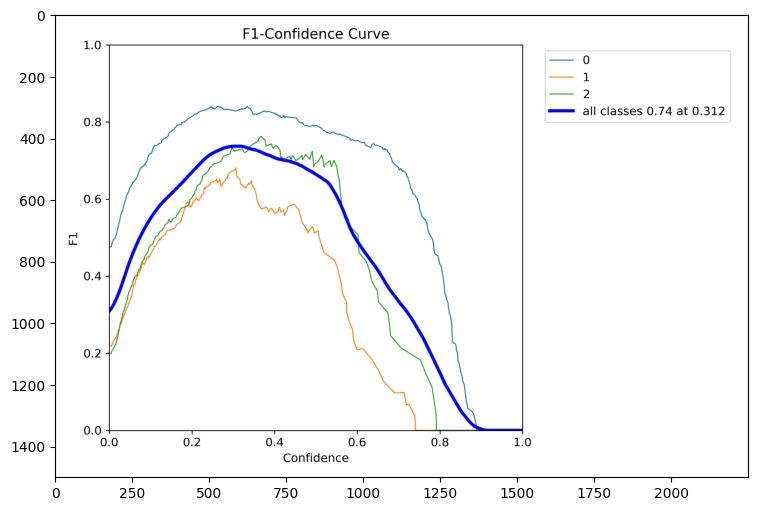

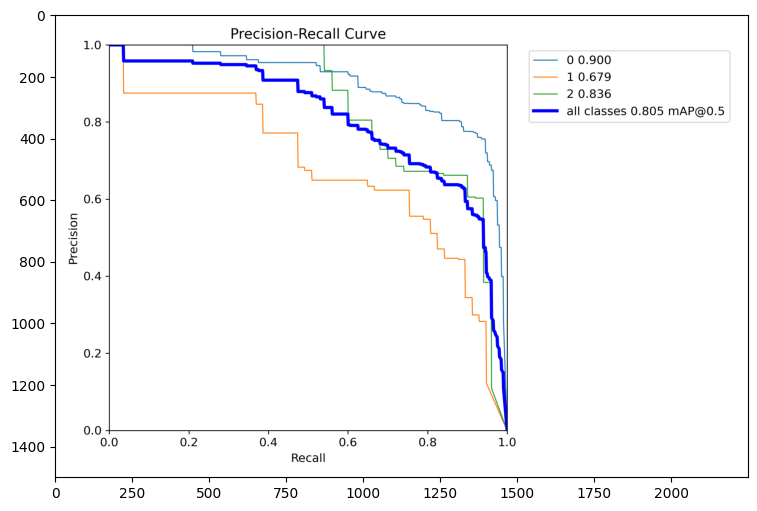

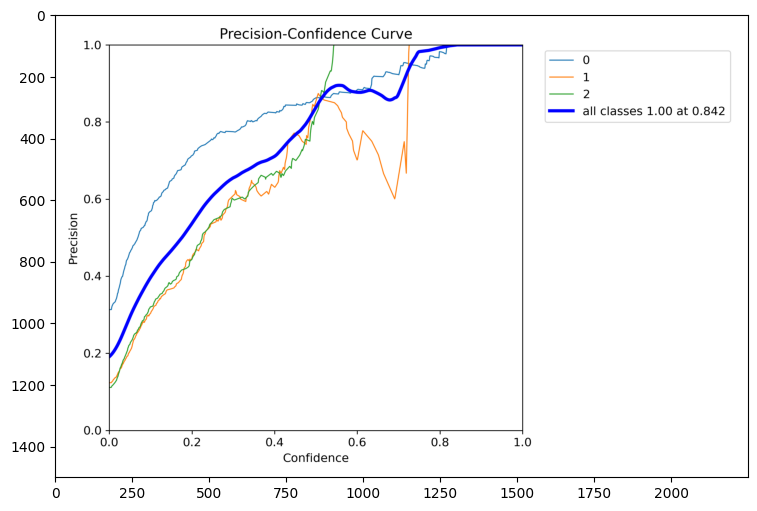

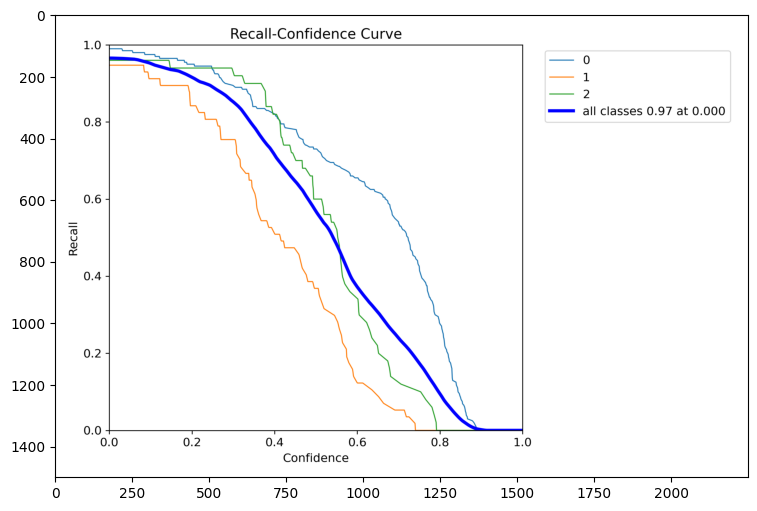

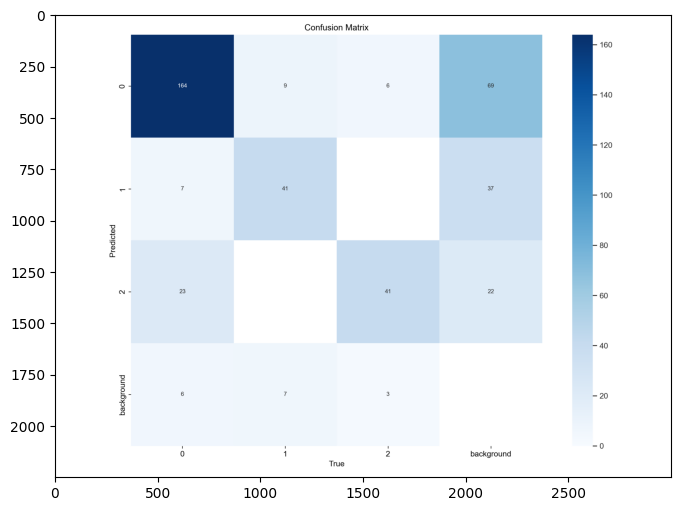

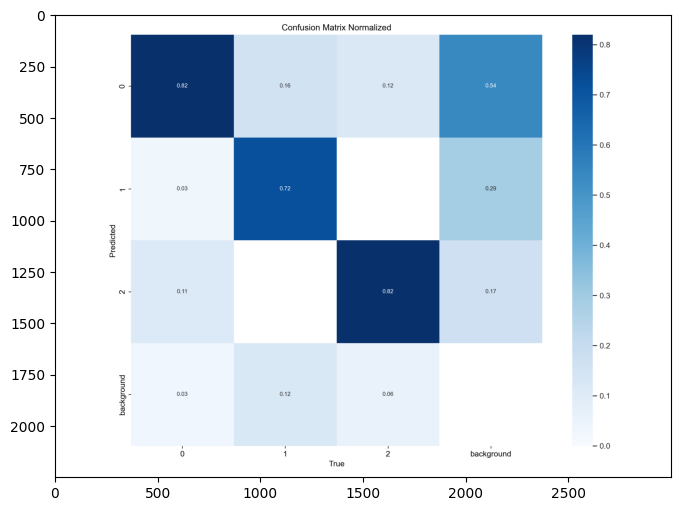

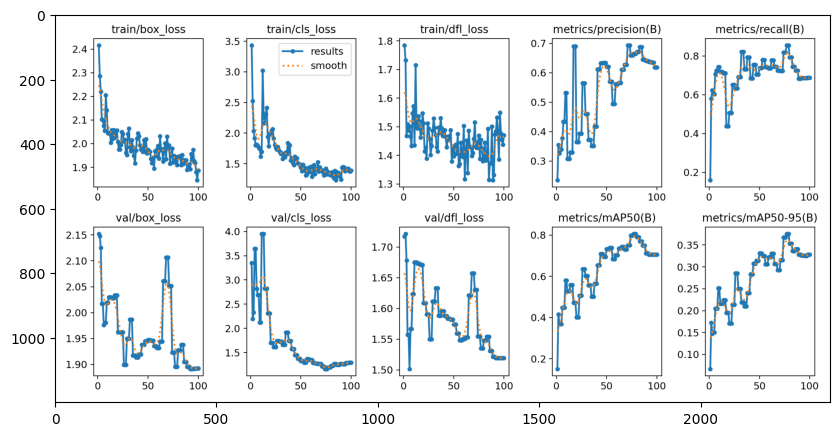

In [98]:
#Visualize training results
TRAIN_RESULTS_PATH = "./runs/detect/train4_divided"

tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.png':
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.show()

./runs/detect/train4_divided\train_batch1.jpg


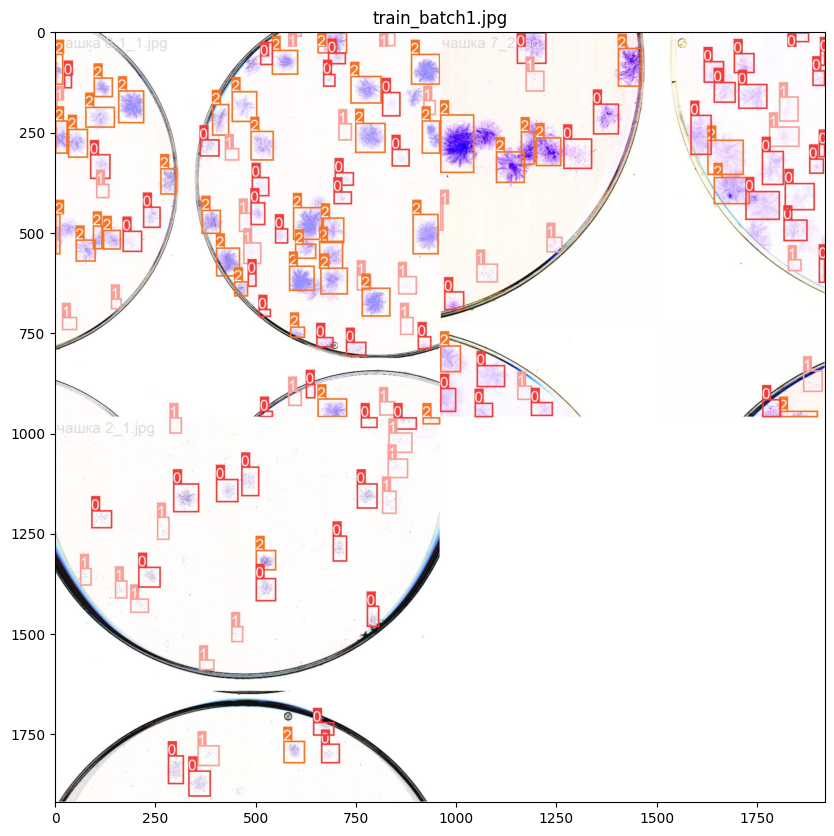

In [99]:
#Visualize batch images
tpaths2=[]
for dirname, _, filenames in os.walk(TRAIN_RESULTS_PATH):
    for filename in filenames:
        if filename[-4:]=='.jpg' and "batch1" in filename:
            tpaths2+=[(os.path.join(dirname, filename))]
tpaths2=sorted(tpaths2)
print(tpaths2[0])

for path in tpaths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.title(path.split('\\')[-1])
    plt.show()

### По результатам обучения видно, что основную трудность составляет класс 1 (Diffuse), так как обьекты небольшие по размеру и в наименьшей степени отличаются от фона изображения. Также видны неточности и неоднозначтности в аннотации обьектов (пропущенные обьекты)

## Inference <a class="anchor" id="inference"></a>

In [159]:
BEST_MODEL = "./runs/detect/train4_divided/weights/best.pt"
SAVE_IMAGE = 'inference_results'

# Process results list
def calc_result(model, images_paths, save_output_im = True, savepath = SAVE_IMAGE):
    output = []
    results = model(images_paths)  # return a list of Results objects
    for i, result in enumerate(results):
        boxes = result.boxes # Boxes object for bounding box outputs
        # result.show()  # display to screen
        if save_output_im:
            result.save(filename=os.path.join(savepath, f'result_{i}.jpg'))  # save to disk
        output.append(result)
    return output


In [160]:
# Load a model
model = YOLO(BEST_MODEL)  # pretrained YOLOv8s model

# Run batched inference on a list of images
dataset_path = os.path.join(DATASET_PATH, 'images', 'valid')
random_image = np.random.choice(os.listdir(dataset_path))
images_paths = [os.path.join(dataset_path,  random_image)]

output = calc_result(model, images_paths, save_output_im = True, savepath = SAVE_IMAGE)



0: 960x960 46 0s, 9 1s, 30 2s, 83.0ms
Speed: 10.0ms preprocess, 83.0ms inference, 2.0ms postprocess per image at shape (1, 3, 960, 960)


In [161]:
#Calculate Predicted object class count
from collections import Counter

classes = output[0].boxes.cls.cpu().numpy()
class_counts = Counter(classes)

print(class_counts)

Counter({0.0: 46, 2.0: 30, 1.0: 9})


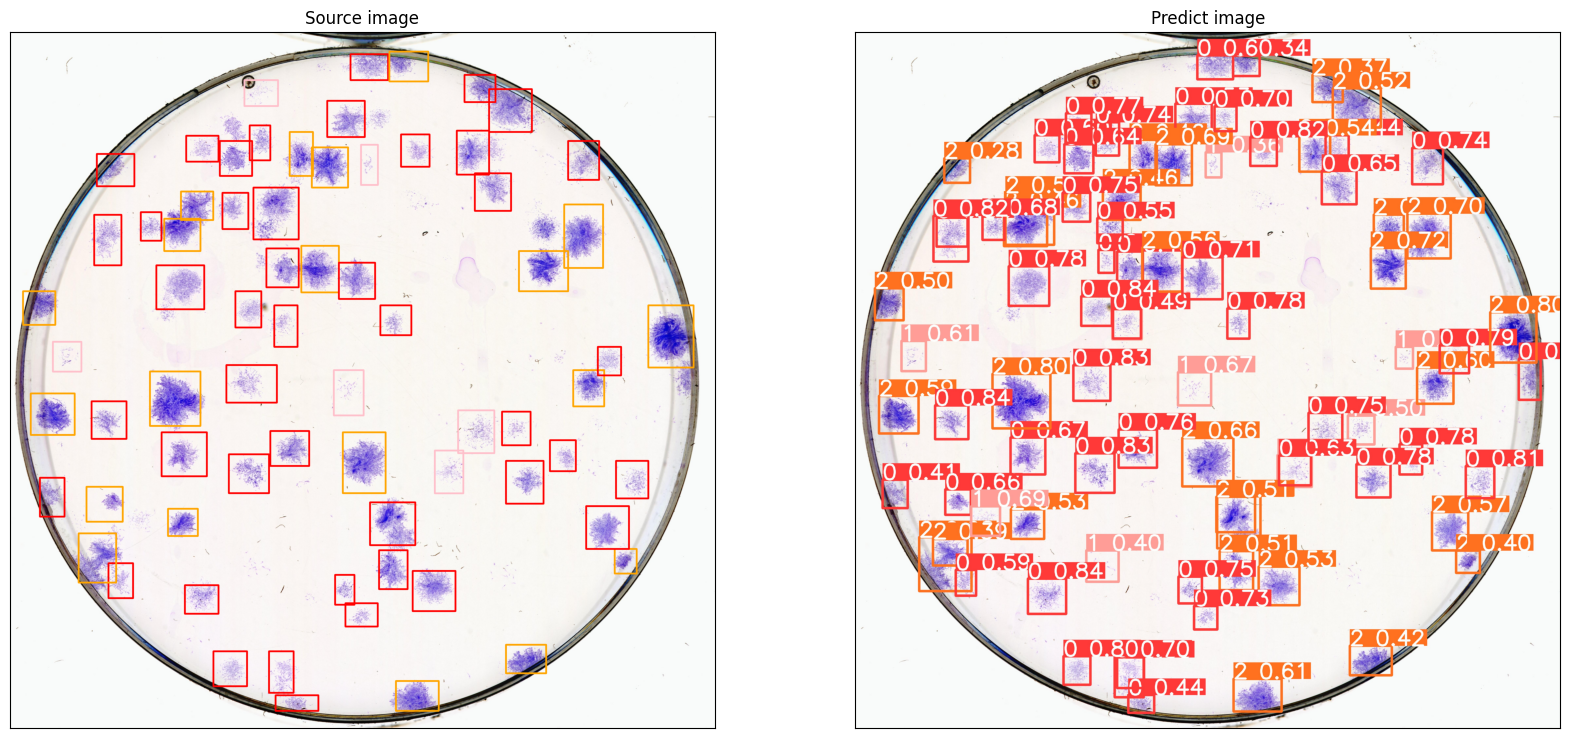

In [162]:
plt.figure(figsize=(20, 20))

image_gt = cv2.imread(images_paths[0])
image_gt = cv2.cvtColor(image_gt, cv2.COLOR_BGR2RGB)

image_data = df[df['filename'] == random_image]
for _, row in image_data.iterrows():
    if row['class_num'] == 0:
        color = (255, 0, 0) # red for 'Mixed'
    elif row['class_num'] == 1:
        color = (255,192,203)  # pink for 'Diffuse'
    elif row['class_num'] == 2:
        color = (255, 165, 0)  # orange for 'Dense'
    else:
        color = (255, 0, 0)   # red for undefined classes
    cv2.rectangle(image_gt, (row.x, row.y), (row.x + row.width, row.y + row.height), color, 10)
            
image_predict = cv2.imread(os.path.join(SAVE_IMAGE, 'result_0.jpg'))
image_predict = cv2.cvtColor(image_predict, cv2.COLOR_BGR2RGB)

plt.subplot(1,2,1), plt.imshow(image_gt), plt.title("Source image")
plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2), plt.imshow(image_predict,'gray'), plt.title("Predict image")
plt.xticks([]),plt.yticks([])
plt.show()


### Пути улучшения:

1. Более детальная разметка
2. Генерация псевдо датасета с помощью GAN
3. Протестировать другие архитектуры и инстанс сегментацию